# Frequency Selective Surface

This example shows how to use PyAEDT to model and simulate a frequency-selective
surface (FSS) by applying the periodic (Floquet) boundary condition at
the boundaries of a unit cell.

Keywords: **HFSS**, **FSS**, **Floquet**.

## Prerequisites

### Perform imports

In [1]:
import tempfile
import time
from pathlib import Path
import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_file

### Define constants
Constants help ensure consistency and avoid repetition throughout the example.

In [2]:
AEDT_VERSION = "2025.2"
NG_MODE = False  # Open AEDT UI when it is launched.

### Create temporary directory

Create a temporary working directory.
The name of the working folder is stored in ``temp_folder.name``.

> **Note:** The final cell in the notebook cleans up the temporary folder. If you want to
> retrieve the AEDT project and data, do so before executing the final cell in the notebook.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
temp_path = Path(temp_folder.name)

### Launch HFSS

The Ansys Electronics Desktop (AEDT) will be launched
and an HFSS design will be inserted into the project.

In [4]:
project_name = temp_path / "FSS.aedt"
hfss = ansys.aedt.core.Hfss(
    version=AEDT_VERSION, 
    project=str(project_name), 
    design="SquarePatch",
    non_graphical=NG_MODE,
    solution_type="Modal",
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_c93206ed-748c-43fe-9060-523a91442485.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 3888.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project FSS has been created.


PyAEDT INFO: Added design 'SquarePatch' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


### Define a parameter

Parameters can be defined in HFSS to run parametric studies. In this example,
``"patch_dim"`` will be used to modify the size of a square conducting
patch in the center of the FSS.

In [5]:
hfss["patch_dim"] = "10mm"

The parameter is assigned to the HFSS design as shown here.
<img src="_static/design_param.svg" width="400">

## Model Preparation

### Define the unit cell

The FSS unit cell will be defined from a 3D component.
The 3D component is downloaded from the 
[example data repository](https://github.com/ansys/example-data/tree/main/pyaedt) 
and inserted into the HFSS design.

1. Download the component.

In [6]:
component_path = Path(download_file("fss_3d_component", local_path=str(temp_path)))

2. Get the file name of the 3D component.
   > **Note:** It should be the only file in the ``component_path`` folder.

In [7]:
unit_cell_paths = [f for f in component_path.glob("*.a3dcomp")]
unit_cell_path = unit_cell_paths[0]

3. Insert the dipole as a 3D component into the HFSS model.
the HFSS model.

In [8]:
comp = hfss.modeler.insert_3d_component(str(unit_cell_path))

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp97mwoxvr.ansys\FSS.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp97mwoxvr.ansys\FSS.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015642404556274414


You can retrieve the names of all 3D components defined in the HFSS design
as shown below. In this case, only one component has been defined.

In [9]:
component_names = hfss.modeler.user_defined_component_names

You can also get the name of each component using the
``name`` property.

Check that only one 3D component has been placed in the HFSS design.

In [10]:
same = comp.name == component_names[0]
if same and len(component_names) == 1:
    msg = f"The single 3D component in this HFSS design is named '{comp.name}'."
else:
    msg ="Something went wrong!"
print(msg)

The single 3D component in this HFSS design is named 'FSS_unitcell_23R2_1'.


### Set component parameters
The 3D component is a parameteric model. 

<img src="_static/comp3d.svg" width="500">

The HFSS parameter ``patch_dim`` can be assigned to
the component parameter ``a`` to modify the size of the patch
in the unit cell.

> **Note:** Multiple instances of a 3D component can be used having different
> parameter values for each instance. For example, consider
> creating a "super-cell" having multiple component instances to improve the bandwidth
> of the FSS.

In [11]:
comp.parameters["a"] = "patch_dim"

### Extend the solution domain

Extend the solution domain in the $+z$ direction. If the
Floquet port is placed too close to the 3D structure, evanescent 
fields on the Floquet port surface can
lead to erroneous results.

The unit cell model is extended away from the 
patch by ``z_extent``. The phase reference
will later be moved back to the surface of the FSS by deembedding the
port solution.

<img src="_static/deembed.svg" width="400">

In [12]:
period_x, period_y, z_dim = hfss.modeler.get_bounding_dimension()

z_extent = 2 * (period_x + period_y)
region = hfss.modeler.create_air_region(
    z_pos=z_extent,
    is_percentage=False,
)

[x_min, y_min, z_min, x_max, y_max, z_max] = region.bounding_box

### Assign boundary conditions and sources

Assign the lattice pair periodic boundary conditions.

In [13]:
boundaries = hfss.auto_assign_lattice_pairs(assignment=region.name)

msg = "The periodic boundary conditions are: "
msg += str(boundaries)
print(msg)

The periodic boundary conditions are: ['LatticePair1', 'LatticePair2']


The Floquet port is asigned to the top surface of the solution domain
where the plane
wave is incident on the FSS. The following arguments
define the periodicity of the FSS.
- ``lattice_origin``
- ``lattice_a_end``
- ``lattice_b_end``

The phase reference is deembedded to the surface of the FSS.

In [14]:
floquet_boundary = hfss.create_floquet_port(
                               assignment=region.top_face_z,
                               lattice_origin=[0, 0, z_max],
                               lattice_a_end=[0, y_max, z_max],
                               lattice_b_end=[x_max, 0, z_max],
                               name="port_z_max",
                               deembed_distance=z_extent,
                               )

PyAEDT INFO: Boundary Floquet Port port_z_max has been created.


### Define solution setup

The solution setup specifies details used to run
the analysis in HFSS. In this example adaptive mesh
refinement runs at 10 GHz while default values are
used for all other settings. 

The frequency sweep is used to specify the range over which scattering
parameters will be calculated.

In [15]:
setup = hfss.create_setup("MySetup")
setup.props["Frequency"] = "10GHz"
setup.props["MaximumPasses"] = 10
hfss.create_linear_count_sweep(
    setup=setup.name,
    units="GHz",
    start_frequency=6,
    stop_frequency=15,
    num_of_freq_points=401,
    name="sweep1",
    sweep_type="Interpolating",
    interpolation_tol=6,
    save_fields=False,
)

PyAEDT INFO: Linear count sweep sweep1 has been correctly created.


MySetup : sweep1

### Run analysis

Save the project and run the analysis.

In [16]:
hfss.save_project()
hfss.analyze()

PyAEDT INFO: Project FSS Saved correctly


PyAEDT INFO: Project FSS Saved correctly


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 7.0s


True

## Postprocess

The syntax used to plot network parameters (S-, Y-, Z-) can be complicated. The
method ``get_traces_for_plot()`` is helpful to retrieve the names of valid
traces to use for ploting.

We'll plot imaginary impedance,  $ \Im (Z_{i,j}) $ 
where $ i $, and $ j $ indices correspond to the two
linear polarization states.

In [17]:
plot_data = hfss.get_traces_for_plot(category="im(Z")
msg = "The imaginary wave impedance can be displayed using "
msg += "the traces\n"
msg += "".join(["--> " + name + "\n" for name in plot_data])
print(msg)

The imaginary wave impedance can be displayed using the traces
--> im(Z(port_z_max:1,port_z_max:1))
--> im(Z(port_z_max:2,port_z_max:2))
--> im(Z(port_z_max:1,port_z_max:2))
--> im(Z(port_z_max:2,port_z_max:1))



The Floquet port was automatically named "port_z_max".
Due to symmetry, only the first two parameters are unique.

### Generate a report in HFSS

In [18]:
report = hfss.post.create_report(plot_data[0:2])

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp97mwoxvr.ansys\FSS.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp97mwoxvr.ansys\FSS.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03170180320739746


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Modal Solution Data


### Retrieve data for postprocessing in Matplotlib

The method ``get_solution_data()`` retrieves data from the report in HFSS 
and makes it available for postprocessing with Matplotlib. 

PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.015685319900512695
Time to initialize solution data:0.015685319900512695


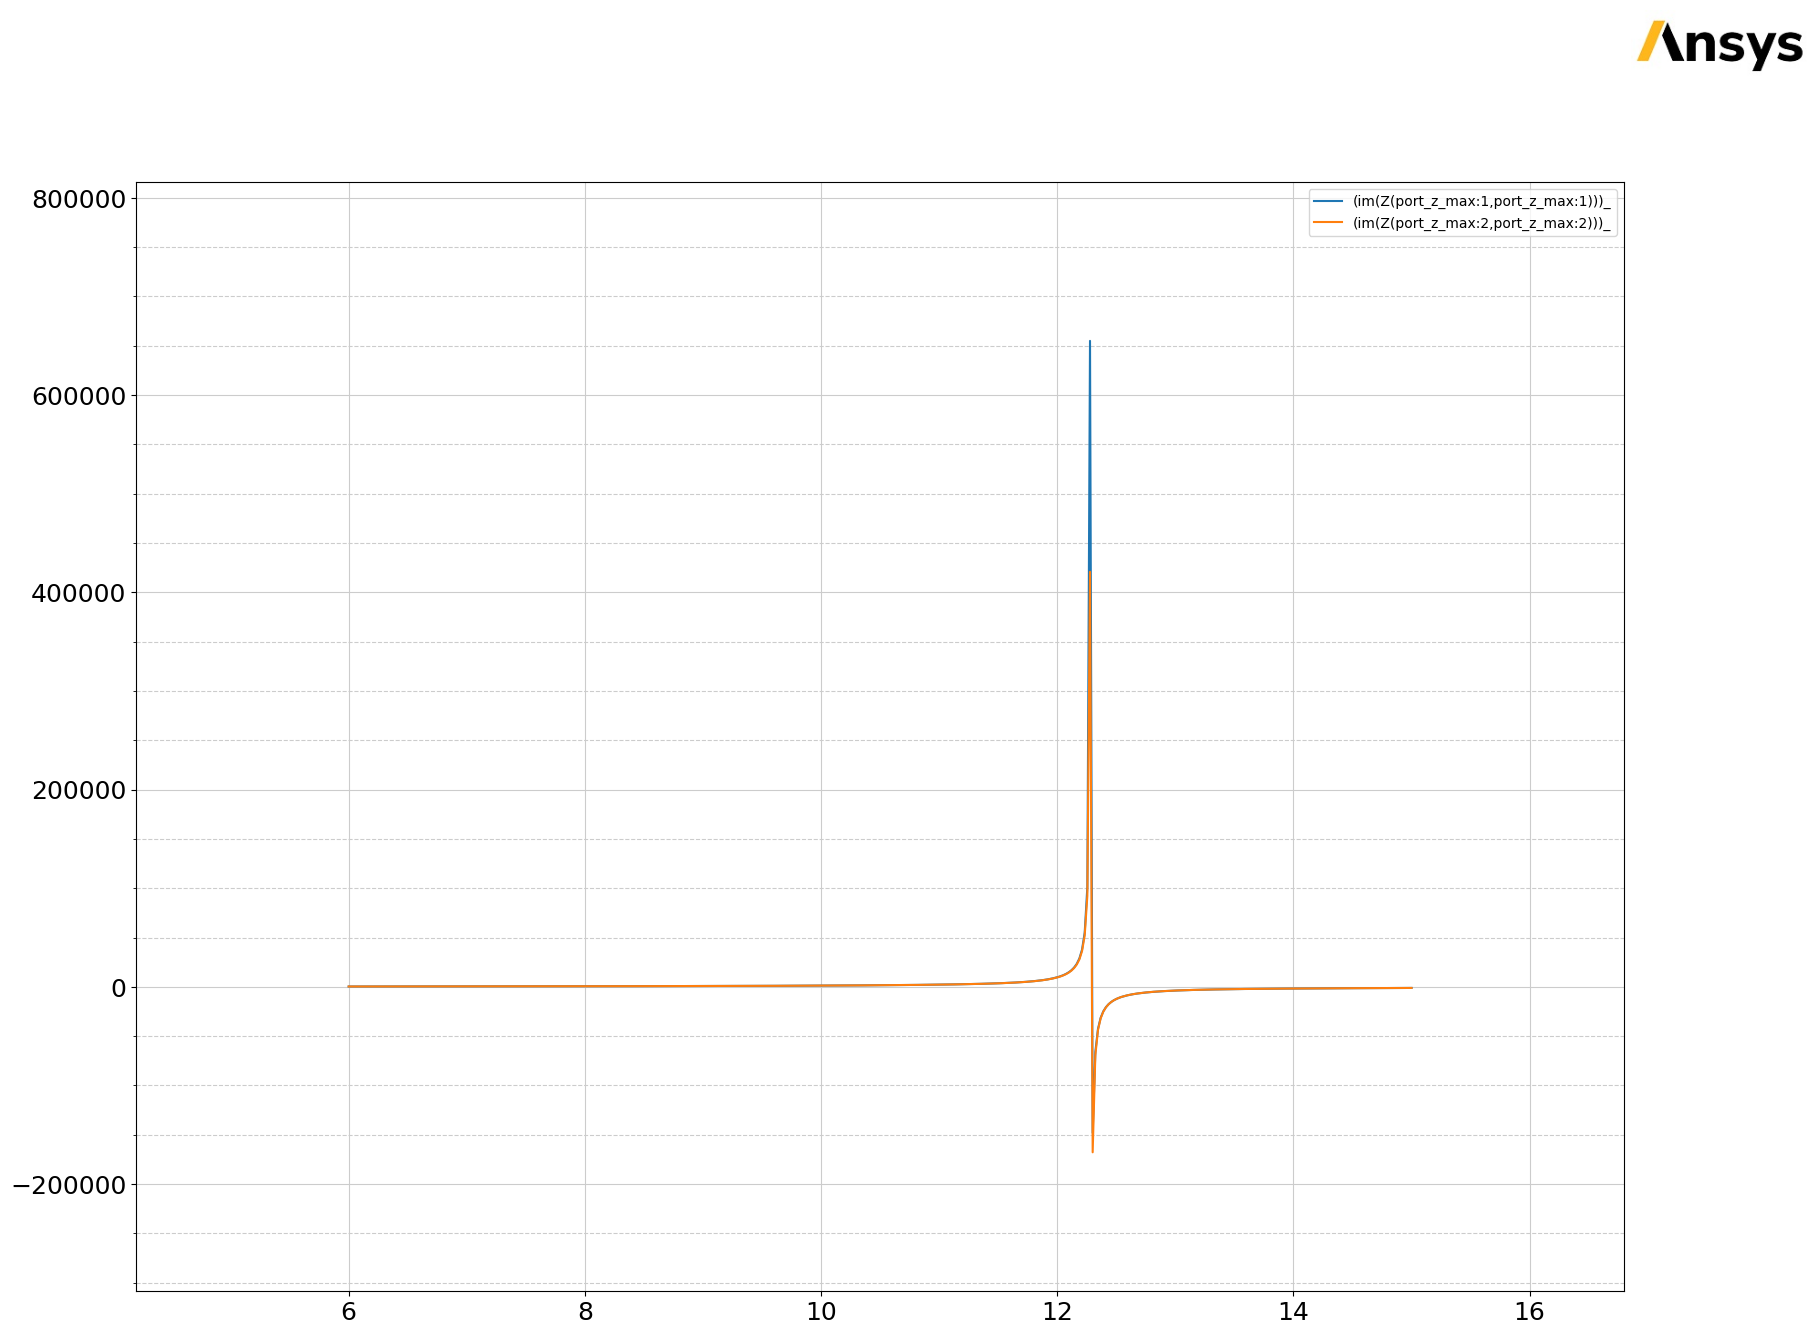

In [19]:
solution = report.get_solution_data()
plt = solution.plot(solution.expressions)

## Release AEDT

In [20]:
hfss.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes
all temporary files, including the project folder.

In [21]:
temp_folder.cleanup()